#Course work research

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install turicreate
!pip install lightfm

     |████████████████████████████████| 92.0MB 64kB/s 
     |████████████████████████████████| 327kB 52.8MB/s 
     |████████████████████████████████| 3.5MB 37.6MB/s 
     |████████████████████████████████| 3.6MB 28.3MB/s 
     |████████████████████████████████| 86.4MB 82kB/s 
     |████████████████████████████████| 18.3MB 247kB/s 
     |████████████████████████████████| 450kB 56.3MB/s 
     |████████████████████████████████| 3.8MB 38.9MB/s 
     |████████████████████████████████| 51kB 2.1MB/s 
  Created wheel for resampy: filename=resampy-0.2.1-cp37-none-any.whl size=320845 sha256=e116a1bddc2f8d8cdba8b49de820afe2f939fe0b69b8c70778d28ba86c05a20d
  Stored in directory: /root/.cache/pip/wheels/ff/4f/ed/2e6c676c23efe5394bb40ade50662e90eb46e29b48324c5f9b
  Created wheel for prettytable: filename=prettytable-0.7.2-cp37-none-any.whl size=13700 sha256=59ad3672c0823beac9e905e7831d1ae2e3aeaf4976edbf99f860d1d699a18851
  Stored in directory: /root/.cache/pip/wheels/80/34/1c/3967380d9676d162cb5951

In [3]:
import pandas as pd
import turicreate as tc
from lightfm import LightFM, data
import numpy as np
import scipy

##Preprocess Movie Frame

In [4]:
movie_frame = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Course Work/movie.csv')

In [5]:
rating_frame = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Course Work/rating.csv')

In [6]:
popularity_frame = rating_frame[['userId', 'movieId']] \
                      .groupby('movieId')  \
                      .count()  \
                      .rename({'userId': 'user_id_count'}, axis='columns')  \
                      .sort_values('user_id_count', ascending=False)
popularity_frame.head()

,user_id_count
movieId,
296,67310
356,66172
318,63366
593,63299
480,59715


In [7]:
def popularity(column):
  if column < 4:
    return 'very low popularity'
  if column < 30:
    return 'low popularity'
  if column > 5000:
    return 'high popularity'
  return 'medium popularity'

In [8]:
popularity_frame['popularity'] = popularity_frame['user_id_count'].apply(popularity)

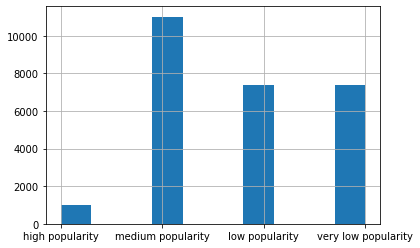

In [9]:
popularity_frame['popularity'].hist()

In [10]:
popoularity_one_hot = popularity_frame['popularity'].str.get_dummies()

In [11]:
max_id = max(movie_frame['movieId'])

In [12]:
movie_frame.set_index('movieId', inplace=True)

In [13]:
movie_frame = movie_frame.join(popoularity_one_hot, on='movieId', how='left')

In [14]:
movie_frame['year'] = movie_frame.title.str.extract('(\(\d\d\d\d\))',expand=False)
movie_frame['year'] = movie_frame.year.str.extract('(\d\d\d\d)',expand=False)

In [15]:
movie_frame['year'] = movie_frame['year'].fillna(1900)

In [16]:
movie_frame['decade'] = movie_frame['year'].apply(lambda x: str(int(x) // 10))
movie_frame['century'] = movie_frame['year'].apply(lambda x: str(int(x) // 100))

In [17]:
movie_frame = movie_frame.join(movie_frame['decade'].str.get_dummies(), how='left')
movie_frame = movie_frame.join(movie_frame['century'].str.get_dummies(), how='left')

In [18]:
movie_frame.drop(['year', 'decade', 'century'], axis=1, inplace=True)

In [19]:
movie_frame = movie_frame.join(movie_frame['genres'].str.get_dummies(), how='left')

In [20]:
movie_frame.drop(['title', 'genres', '(no genres listed)'], axis=1, inplace=True)

In [21]:
movie_frame.head()

,high popularity,low popularity,medium popularity,very low popularity,189,190,191,192,193,194,195,196,197,198,199,200,201,18,19,20,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
5,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [22]:
movie_frame.shape

(27278, 39)

In [23]:
max_id

131262

In [24]:
dummy_frame = pd.DataFrame(data=np.arange(max_id + 1), columns=['movieId']).set_index('movieId')
dummy_frame

""
movieId
0
1
2
3
4
...
131258
131259
131260


In [25]:
movie_frame = movie_frame.join(dummy_frame, how='right', on='movieId').set_index('movieId').fillna(0)

## LightFM

In [44]:
from scipy.sparse import coo_matrix, csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

In [27]:
user_movie_frame = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Course Work/rating.csv')

In [28]:
user_movie_frame.drop('timestamp', axis=1, inplace=True)

In [29]:
user_movie_frame.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


In [30]:
users_count = max(user_movie_frame['userId']) + 1
movies_count = max(user_movie_frame['movieId']) + 1
users_count, movies_count

(138494, 131263)

In [31]:
def encode_binary(x):
    return 1 if x > 4 else -1

user_movie_frame['rating'] = user_movie_frame['rating'].apply(encode_binary)

In [32]:
user_movie_frame.head(5)

,userId,movieId,rating
0,1,2,-1
1,1,29,-1
2,1,32,-1
3,1,47,-1
4,1,50,-1


In [33]:
training_frame, test_frame = train_test_split(user_movie_frame, test_size=0.2, random_state=125)

In [34]:
rating_frame_sparse = coo_matrix((training_frame['rating'], (training_frame['userId'], training_frame['movieId'])), shape=(users_count, movies_count))

In [35]:
rating_frame_sparse_test = coo_matrix((test_frame['rating'], (test_frame['userId'], test_frame['movieId'])), shape=(users_count, movies_count))

In [36]:
rating_frame_sparse

<138494x131263 sparse matrix of type '<class 'numpy.int64'>'
	with 16000210 stored elements in COOrdinate format>

In [37]:
movies_features_sparsed = scipy.sparse.csr_matrix(movie_frame.values)

In [38]:
movies_features_sparsed

<131263x39 sparse matrix of type '<class 'numpy.float64'>'
	with 135460 stored elements in Compressed Sparse Row format>

In [39]:
model = LightFM(random_state=125)
model.fit(rating_frame_sparse, item_features=movies_features_sparsed)

In [42]:
def roc_auc(y_true, y_pred):
    labels = [0 if i < 0 else 1 for i in y_true]
    return roc_auc_score(labels, y_pred)

roc_auc_scorer = make_scorer(
    roc_auc
)

##Hyperparams tuning

In [47]:
no_components_range = np.arange(5, 51, 5)

y_true = test_frame['rating']

roc_auc_no_comp = []

for no_components in no_components_range:
    print(f'no_components = {no_components}')
    model = LightFM(random_state=125, no_components=no_components)
    model.fit(rating_frame_sparse, item_features=movies_features_sparsed)
    predictions = model.predict(user_ids=np.array(test_frame['userId']),
                                item_ids=np.array(test_frame['movieId']), 
                                item_features=movies_features_sparsed)
    roc_auc_no_comp.append(roc_auc(y_true, predictions))
    print(f'ROC AUC score = {roc_auc_no_comp[-1]}')

no_components = 5
ROC AUC score = 0.7630329163544235
no_components = 10
ROC AUC score = 0.770198067699336
no_components = 15
ROC AUC score = 0.7711545115081804
no_components = 20
ROC AUC score = 0.772115717476979
no_components = 25
ROC AUC score = 0.7724043739040879
no_components = 30
ROC AUC score = 0.7726613553255003
no_components = 35
ROC AUC score = 0.7729202597663732
no_components = 40
ROC AUC score = 0.7729027258318115
no_components = 45
ROC AUC score = 0.7729942603366535
no_components = 50
ROC AUC score = 0.772914641774155


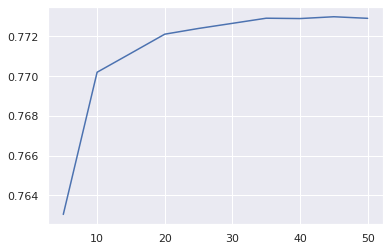

In [48]:
plt.plot(no_components_range, roc_auc_no_comp)

In [50]:
best_no_comp = no_components_range[np.argmax(roc_auc_no_comp)]
best_no_comp

45

In [51]:
user_alphas = np.logspace(-8, 0, 10)

y_true = test_frame['rating']

roc_auc_alphas = []

for user_alpha in user_alphas:
    print(f'user_alpha = {user_alpha}')
    model = LightFM(random_state=125, 
                    no_components=best_no_comp, 
                    user_alpha=user_alpha)
    model.fit(rating_frame_sparse, item_features=movies_features_sparsed)
    predictions = model.predict(user_ids=np.array(test_frame['userId']), 
                                item_ids=np.array(test_frame['movieId']), 
                                item_features=movies_features_sparsed)
    roc_auc_alphas.append(roc_auc(y_true, predictions))
    print(f'ROC AUC score = {roc_auc_alphas[-1]}')

user_alpha = 1e-08
ROC AUC score = 0.7729973724371519
user_alpha = 7.742636826811277e-08
ROC AUC score = 0.7730124127238298
user_alpha = 5.994842503189409e-07
ROC AUC score = 0.7727405102840382
user_alpha = 4.641588833612773e-06
ROC AUC score = 0.7406266131376509
user_alpha = 3.5938136638046256e-05
ROC AUC score = 0.6342273928351825
user_alpha = 0.0002782559402207126
ROC AUC score = 0.6134830646085657
user_alpha = 0.002154434690031882
ROC AUC score = 0.634505468993823
user_alpha = 0.016681005372000558
ROC AUC score = 0.6351184007470108
user_alpha = 0.12915496650148828
ROC AUC score = 0.636653782674919
user_alpha = 1.0
ROC AUC score = 0.6364395891912215


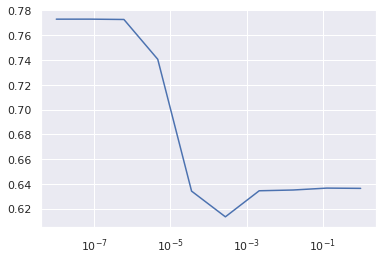

In [52]:
plt.plot(user_alphas, roc_auc_alphas)
plt.xscale('log')
# plt.ylim([0.4, 0.6])

In [53]:
best_alpha = user_alphas[np.argmax(roc_auc_alphas)]
best_alpha

7.742636826811277e-08

##Final predictions

In [54]:
y_true = test_frame['rating']
model = LightFM(random_state=125, 
                no_components=best_no_comp, 
                user_alpha=best_alpha,
                learning_schedule='adagrad')
model.fit(rating_frame_sparse, item_features=movies_features_sparsed)
predictions = model.predict(user_ids=np.array(test_frame['userId']), 
                            item_ids=np.array(test_frame['movieId']), 
                            item_features=movies_features_sparsed)

In [55]:
roc_auc(y_true, predictions)

0.7730124127238298

In [56]:
predictions_train = model.predict(user_ids=np.array(training_frame['userId']), 
                            item_ids=np.array(training_frame['movieId']), 
                            item_features=movies_features_sparsed)

In [57]:
y_true_train = training_frame['rating']

In [58]:
roc_auc(y_true_train, predictions_train)

0.8078161672255583